### Data
The code below reads in Geotiff files from NASA Socioeconomic Data and Applications Center (SEDAC)
Documentation for the U.S. Social Vulnerability Index Grids, v1 (2000, 2010, 2014, 2016, 2018).

Using the gdal from the osgeo package, latitude and longitude values are generated for each pixel in the raster.
The raster values are then read into a Pandas DataFrame with the latitude and longitude values as columns.
The resulting DataFrame is then merged with the other years to create a single DataFrame with all years and economic values whcih include: Socioeconomic Ranking, Household Composition & Disability, Minority Status & Language, Housing Type & Transportation, and overall Social Vulnerability Index Ranking.

In [1]:
#base dependencies
import pandas as pd
import numpy as np

#GIS packages
from osgeo import gdal
from geopy.geocoders import Nominatim
import geopandas as gpd
import georasters as gr
from shapely.geometry import Point


#utility packages
import os
import requests 
from bs4 import BeautifulSoup
import re
# from google.cloud import storage

#plots
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio
pio.renderers.default='notebook'

### Raw Data

In [2]:
# # Raw data as geoTifs hosted on GitHub Repo
tif_urls_2016 = ["https://github.com/DanDryer/Team-Project-Practicum-6748/raw/main/SEDAC_SVI_data/svi_2016_tract_household_nad83_nopop.tif",
            "https://github.com/DanDryer/Team-Project-Practicum-6748/raw/main/SEDAC_SVI_data/svi_2016_tract_housing_nad83_nopop.tif",
            "https://github.com/DanDryer/Team-Project-Practicum-6748/raw/main/SEDAC_SVI_data/svi_2016_tract_minority_nad83_nopop.tif",
            "https://github.com/DanDryer/Team-Project-Practicum-6748/raw/main/SEDAC_SVI_data/svi_2016_tract_overall_nad83_nopop.tif",
            "https://github.com/DanDryer/Team-Project-Practicum-6748/raw/main/SEDAC_SVI_data/svi_2016_tract_socioeconomic_nad83_nopop.tif",
           ]
tif_urls_2018 = [
            "https://github.com/DanDryer/Team-Project-Practicum-6748/raw/main/SEDAC_SVI_data/svi_2018_tract_household_nad83_nopop.tif",
            "https://github.com/DanDryer/Team-Project-Practicum-6748/raw/main/SEDAC_SVI_data/svi_2018_tract_housing_nad83_nopop.tif",
            "https://github.com/DanDryer/Team-Project-Practicum-6748/raw/main/SEDAC_SVI_data/svi_2018_tract_minority_nad83_nopop.tif",
            "https://github.com/DanDryer/Team-Project-Practicum-6748/raw/main/SEDAC_SVI_data/svi_2018_tract_overall_nad83_nopop.tif",
            "https://github.com/DanDryer/Team-Project-Practicum-6748/raw/main/SEDAC_SVI_data/svi_2018_tract_socioeconomic_nad83_nopop.tif"
        ]


In [3]:
# Added this pathing since the direct links did not work for me
# Raw data as geoTifs hosted on GitHub Repo
#tif_urls = ["./SEDAC_SVI_data/svi_2014_tract_household_nad83_nopop.tif",
#            "./SEDAC_SVI_data/svi_2014_tract_housing_nad83_nopop.tif",
#            "./SEDAC_SVI_data/svi_2014_tract_minority_nad83_nopop.tif",
#            "./SEDAC_SVI_data/svi_2014_tract_overall_nad83_nopop.tif",
#            "./SEDAC_SVI_data/svi_2014_tract_socioeconomic_nad83_nopop.tif",
#            "./SEDAC_SVI_data/svi_2016_tract_household_nad83_nopop.tif",
#            "./SEDAC_SVI_data/svi_2016_tract_housing_nad83_nopop.tif",
#            "./SEDAC_SVI_data/svi_2016_tract_minority_nad83_nopop.tif",
#            "./SEDAC_SVI_data/svi_2016_tract_overall_nad83_nopop.tif",
#            "./SEDAC_SVI_data/svi_2016_tract_socioeconomic_nad83_nopop.tif",
#            "./SEDAC_SVI_data/svi_2018_tract_household_nad83_nopop.tif",
#            "./SEDAC_SVI_data/svi_2018_tract_housing_nad83_nopop.tif",
#            "./SEDAC_SVI_data/svi_2018_tract_minority_nad83_nopop.tif",
#            "./SEDAC_SVI_data/svi_2018_tract_overall_nad83_nopop.tif",
#            "./SEDAC_SVI_data/svi_2018_tract_socioeconomic_nad83_nopop.tif"
#            ]

### Data Cleaning

In [23]:
def geotif_to_pandas(path, value_name):
    """
    This function converts a GeoTIFF file to a GeoDataFrame and adds latitude and longitude values for each pixel
    :param path: The path to the GeoTIFF file
    :param value_name: The name of the column for raster values in the GeoDataFrame
    :return: A GeoDataFrame with latitude, longitude, and raster values
    """
    # Read the GeoTIFF file 
    geotif = gr.from_file(path)
    
    #converts to pandas df
    geodf = geotif.to_pandas()

    # Extract the latitude, longitude, and raster values
    df = geodf.loc[:,[True, # Raster values
                      'x', # Longitude
                      'y']]# Latitude
    
    # Rename columns
    column_names = {True: value_name, 'x': 'Longitude', 'y' : 'Latitude'} 
    df = df.rename(columns=column_names)
    
    return df
def join_vars(tif_urls):
    """
    Takes in a list of urls that contains geotiff files for SEDAC SVI economic data
    Iterates through list of urls and determines value name from file name
    Converts geotiff to pandas df with raster value converted to column with value name
    Appends df to a list of dfs
    """
    # List of dfs for each processed geotiff file
    dfs = []
    
    # Iterate through tif_urls and process each file
    for tif_url in tif_urls:
        # Extract the year and value name from the URL
        filename = os.path.basename(tif_url)
        match = re.search(r"svi_(\d+)_tract_([a-zA-Z]+)", filename)
        if match:
            year = match.group(1)
            value_name = match.group(2)

            # Call geotif_to_pandas function with the appropriate arguments
            df = geotif_to_pandas(tif_url, value_name)
            
            # add year column
            df['year'] = int(year)
        
            # Append the df to list
            dfs.append(df)
        else:
            pass
    return dfs


def add_county(df):
    
    """
    This function uses the latitude and longitude data and US county polygons file to add county columns to the df.
    :param df: The dataframe that the county information will be added to
    :return: A Pandas DataFrame with latitude, longitude, raster values, and county
    """
    # Download the county boundaries here under Shapefile: https://public.opendatasoft.com/explore/dataset/us-county-boundaries/export/?disjunctive.statefp&amp;disjunctive.countyfp&amp;disjunctive.name&amp;disjunctive.namelsad&amp;disjunctive.stusab&amp;disjunctive.state_name&disjunctive.countyfp&disjunctive.name&disjunctive.namelsad&disjunctive.stusab&disjunctive.state_name
    # May need to update file path depending on where the us-county-boundaries.shp is stored

    file_path = r"./us-county-boundaries/us-county-boundaries.shp"
    counties = gpd.GeoDataFrame.from_file(file_path)

    df['Coords'] = list(zip(df['Longitude'],df['Latitude']))
    df['Coords'] = df['Coords'].apply(Point)
    points = gpd.GeoDataFrame(df, geometry='Coords', crs=counties.crs)
    pointInPolys = gpd.tools.sjoin(points, counties, predicate="within", how='left')
    pointInPolys.to_csv("withcountyID.csv") 

    return df

In [24]:
# Creating list of dfs for 5 SVI vars from SEDAC data
dfs_2016 = join_vars(tif_urls_2016)
dfs_2018 = join_vars(tif_urls_2018)
    
# Perform inner join on 'Latitude' and 'Longitude' for 2016 data
df_merged_2016 = dfs_2016[0]  # Start with the first DataFrame

for df in dfs_2016[1:]:
    df_merged_2016 = pd.merge(df_merged_2016, df, on=['Latitude', 'Longitude', 'year'], how='inner')
    
# Perform inner join on 'Latitude' and 'Longitude' for 2018 data
df_merged_2018 = dfs_2018[0]  # Start with the first DataFrame

for df in dfs_2018[1:]:
    df_merged_2018 = pd.merge(df_merged_2018, df, on=['Latitude', 'Longitude', 'year'], how='inner')

#concatonate 2016 and 2018
df_svi = pd.concat([df_merged_2016, df_merged_2018], ignore_index=True)

### Impute 2017 values

In [25]:
# Filter the dataframe for rows with year 2016 and 2018
df_2016 = df_svi[df_svi['year'] == 2016]
df_2018 = df_svi[df_svi['year'] == 2018]

# Group by 'Latitude' and 'Longitude' and calculate the mean for desired columns
grouped_df = df_svi.groupby(['Latitude', 'Longitude'])['household', 'housing', 'minority', 'overall', 'socioeconomic'].mean().reset_index()

# Create a new dataframe for year 2017 with mean values
df_2017 = grouped_df.copy()
df_2017['year'] = 2017

# Append the new observations to the original dataframe
df_svi = pd.concat([df_svi, df_2017], ignore_index=True)


/var/folders/2n/1ydmmpks7h77zv7p1k6l11pc0000gn/T/ipykernel_6679/459847936.py:6: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [8]:
# Exports df_svi to csv zip
#compression_opts = dict(method='zip', archive_name='out.csv')
#df_svi.to_csv('out.zip', index=True, compression=compression_opts) 

In [26]:
df_svi.head()

,household,Longitude,Latitude,year,housing,minority,overall,socioeconomic
0,0.4909,-156.350000,71.366666,2016,0.9908,0.746,0.8641,0.6767
1,0.4909,-156.341667,71.366666,2016,0.9908,0.746,0.8641,0.6767
2,0.4909,-156.608333,71.349999,2016,0.9908,0.746,0.8641,0.6767
3,0.4909,-156.600000,71.349999,2016,0.9908,0.746,0.8641,0.6767
4,0.4909,-156.591667,71.349999,2016,0.9908,0.746,0.8641,0.6767


### Create new delta values

### Add counties with US county polygons

In [27]:
add_county(df_svi)

,household,Longitude,Latitude,year,housing,minority,overall,socioeconomic,Coords
0,0.4909,-156.350000,71.366666,2016,0.9908,0.7460,0.8641,0.6767,POINT (-156.35000009418033 71.36666602140002)
1,0.4909,-156.341667,71.366666,2016,0.9908,0.7460,0.8641,0.6767,POINT (-156.34166676088032 71.36666602140002)
2,0.4909,-156.608333,71.349999,2016,0.9908,0.7460,0.8641,0.6767,POINT (-156.60833342648056 71.34999935480006)
3,0.4909,-156.600000,71.349999,2016,0.9908,0.7460,0.8641,0.6767,POINT (-156.60000009318057 71.34999935480006)
4,0.4909,-156.591667,71.349999,2016,0.9908,0.7460,0.8641,0.6767,POINT (-156.59166675988055 71.34999935480006)
...,...,...,...,...,...,...,...,...,...
27488911,0.5641,-156.591667,71.349999,2017,0.9886,0.7542,0.8707,0.6607,POINT (-156.59166675988055 71.34999935480006)
27488912,0.5641,-156.583333,71.349999,2017,0.9886,0.7542,0.8707,0.6607,POINT (-156.58333342658054 71.34999935480006)
27488913,0.5641,-156.575000,71.349999,2017,0.9886,0.7542,0.8707,0.6607,POINT (-156.57500009328055 71.34999935480006)
27488914,0.5641,-156.350000,71.366666,2017,0.9886,0.7542,0.8707,0.6607,POINT (-156.35000009418033 71.36666602140002)


In [14]:
#importing older sile with counties to get county values
df_svi_counties = pd.read_csv('SEDAC_2014-2018_withcountyID.csv')

In [52]:

df_svi_counties.head()

,Unnamed: 0,2014_household,Longitude,Latitude,2014_housing,2014_minority,2014_overall,2014_socioeconomic,2016_household,2016_housing,...,csafp,cbsafp,metdivfp,funcstat,aland,awater,intptlat,intptlon,state_name,countyfp_no
0,0,0.655,-156.350000,71.366666,0.9882,0.7986,0.8776,0.6451,0.4909,0.9908,...,NaN,NaN,NaN,A,2.300542e+11,1.554894e+10,69.449343,-153.47283,Alaska,185.0
1,1,0.655,-156.341667,71.366666,0.9882,0.7986,0.8776,0.6451,0.4909,0.9908,...,NaN,NaN,NaN,A,2.300542e+11,1.554894e+10,69.449343,-153.47283,Alaska,185.0
2,2,0.655,-156.608333,71.349999,0.9882,0.7986,0.8776,0.6451,0.4909,0.9908,...,NaN,NaN,NaN,A,2.300542e+11,1.554894e+10,69.449343,-153.47283,Alaska,185.0
3,3,0.655,-156.600000,71.349999,0.9882,0.7986,0.8776,0.6451,0.4909,0.9908,...,NaN,NaN,NaN,A,2.300542e+11,1.554894e+10,69.449343,-153.47283,Alaska,185.0
4,4,0.655,-156.591667,71.349999,0.9882,0.7986,0.8776,0.6451,0.4909,0.9908,...,NaN,NaN,NaN,A,2.300542e+11,1.554894e+10,69.449343,-153.47283,Alaska,185.0


In [51]:
df_svi_counties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9153038 entries, 0 to 9153037
Data columns (total 55 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   Unnamed: 0                           int64  
 1   2014_household                       float64
 2   Longitude                            float64
 3   Latitude                             float64
 4   2014_housing                         float64
 5   2014_minority                        float64
 6   2014_overall                         float64
 7   2014_socioeconomic                   float64
 8   2016_household                       float64
 9   2016_housing                         float64
 10  2016_minority                        float64
 11  2016_overall                         float64
 12  2016_socioeconomic                   float64
 13  2018_household                       float64
 14  2018_housing                         float64
 15  2018_minority                   

In [40]:
df_svi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27488916 entries, 0 to 27488915
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   household      float32
 1   Longitude      float64
 2   Latitude       float64
 3   year           int64  
 4   housing        float32
 5   minority       float32
 6   overall        float32
 7   socioeconomic  float32
 8   Coords         object 
dtypes: float32(5), float64(2), int64(1), object(1)
memory usage: 1.3+ GB


In [63]:
#small df for test
df_svi_sm = df_svi.sample(n=100, random_state=42)

final_df_sm = df_svi_sm.merge(df_svi_counties[['Latitude', 'Longitude', 'state_name', 'countyfp_no',
                                            'namelsad', 'name', 'stusab', 'geoid', 'intptlon', 'intptlat']],
                                        on=['Latitude', 'Longitude'], how='left')

In [64]:
# merging to add geograohic data
final_df = df_svi.merge(df_svi_counties[['Latitude', 'Longitude', 'state_name', 'countyfp_no',
                                        'namelsad', 'name', 'stusab', 'geoid', 'intptlon', 'intptlat']],
                                        on=['Latitude', 'Longitude'], how='left')

In [66]:
final_df.head()

,household,Longitude,Latitude,year,housing,minority,overall,socioeconomic,Coords,state_name,countyfp_no,namelsad,name,stusab,geoid,intptlon,intptlat
0,0.4909,-156.350000,71.366666,2016,0.9908,0.746,0.8641,0.6767,POINT (-156.35000009418033 71.36666602140002),Alaska,185.0,North Slope Borough,North Slope,AK,2185.0,-153.47283,69.449343
1,0.4909,-156.341667,71.366666,2016,0.9908,0.746,0.8641,0.6767,POINT (-156.34166676088032 71.36666602140002),Alaska,185.0,North Slope Borough,North Slope,AK,2185.0,-153.47283,69.449343
2,0.4909,-156.608333,71.349999,2016,0.9908,0.746,0.8641,0.6767,POINT (-156.60833342648056 71.34999935480006),Alaska,185.0,North Slope Borough,North Slope,AK,2185.0,-153.47283,69.449343
3,0.4909,-156.600000,71.349999,2016,0.9908,0.746,0.8641,0.6767,POINT (-156.60000009318057 71.34999935480006),Alaska,185.0,North Slope Borough,North Slope,AK,2185.0,-153.47283,69.449343
4,0.4909,-156.591667,71.349999,2016,0.9908,0.746,0.8641,0.6767,POINT (-156.59166675988055 71.34999935480006),Alaska,185.0,North Slope Borough,North Slope,AK,2185.0,-153.47283,69.449343


### Join OCO2 Data (Smalled dataset with annual mean by geoid)

In [77]:
# read in data from Dan's OCO2 data cleaning notebook
df_oco2 = pd.read_csv('OCO2_CLEANED_2015-2022_V1.csv')

In [78]:
#filter years 2016-2018
df_oco2 = df_oco2[(df_oco2['Year'] >= 2016) & (df_oco2['Year'] <= 2018)]
df_oco2 = df_oco2.rename(columns={'Year': 'year', 'delta': 'co2_delta', 
                                  'total_delta':'co2_cum_delta', 
                                  'pct_change':'co2_pct_change'})

In [79]:
df_oco2.head()

,Unnamed: 0,geoid,county_name,state_name,year,readings_count,stddev_xco2,avg_xco2,co2_delta,co2_cum_delta,co2_pct_change
1,1,1001,Autauga,Alabama,2016,268,1.087421,403.38025,7.122742,7.122742,1.017975
2,2,1001,Autauga,Alabama,2017,67,1.190920,403.87670,0.496460,7.619202,1.001231
3,3,1001,Autauga,Alabama,2018,437,2.605162,408.49088,4.614166,12.233368,1.011425
9,9,1003,Baldwin,Alabama,2016,739,2.128407,402.85437,1.651855,1.651855,1.004117
10,10,1003,Baldwin,Alabama,2017,445,1.272559,406.67250,3.818115,5.469971,1.009478


In [82]:
# Join with SEDAC Data on geoid and year
df_svi = final_df.merge(df_oco2, on=['geoid', 'year'], how='left')

In [88]:
df_svi.head()

,household,Longitude,Latitude,year,housing,minority,overall,socioeconomic,Coords,state_name_x,...,intptlat,Unnamed: 0,county_name,state_name_y,readings_count,stddev_xco2,avg_xco2,co2_delta,co2_cum_delta,co2_pct_change
0,0.4909,-156.350000,71.366666,2016,0.9908,0.746,0.8641,0.6767,POINT (-156.35000009418033 71.36666602140002),Alaska,...,69.449343,603.0,North Slope,Alaska,15954.0,3.604313,400.48508,3.850678,3.850678,1.009708
1,0.4909,-156.341667,71.366666,2016,0.9908,0.746,0.8641,0.6767,POINT (-156.34166676088032 71.36666602140002),Alaska,...,69.449343,603.0,North Slope,Alaska,15954.0,3.604313,400.48508,3.850678,3.850678,1.009708
2,0.4909,-156.608333,71.349999,2016,0.9908,0.746,0.8641,0.6767,POINT (-156.60833342648056 71.34999935480006),Alaska,...,69.449343,603.0,North Slope,Alaska,15954.0,3.604313,400.48508,3.850678,3.850678,1.009708
3,0.4909,-156.600000,71.349999,2016,0.9908,0.746,0.8641,0.6767,POINT (-156.60000009318057 71.34999935480006),Alaska,...,69.449343,603.0,North Slope,Alaska,15954.0,3.604313,400.48508,3.850678,3.850678,1.009708
4,0.4909,-156.591667,71.349999,2016,0.9908,0.746,0.8641,0.6767,POINT (-156.59166675988055 71.34999935480006),Alaska,...,69.449343,603.0,North Slope,Alaska,15954.0,3.604313,400.48508,3.850678,3.850678,1.009708


In [89]:
#export to csv
df_svi.to_csv('SVI_CO2_2016-2018.csv', index=False)

### Data Visualization

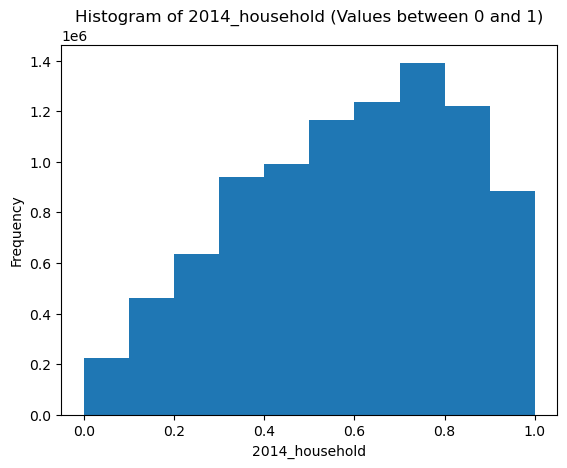

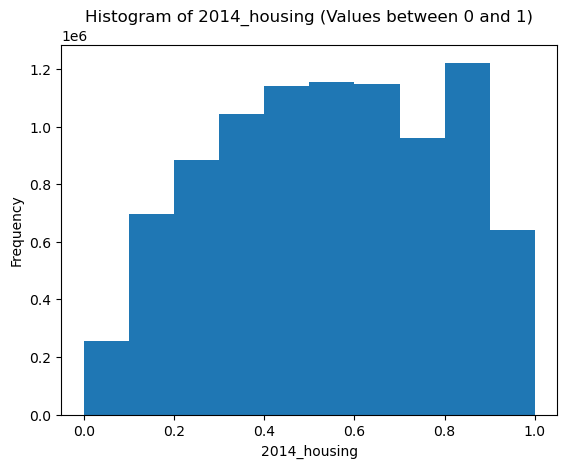

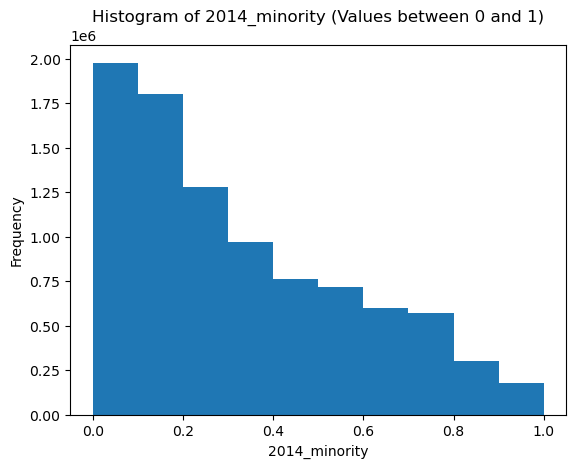

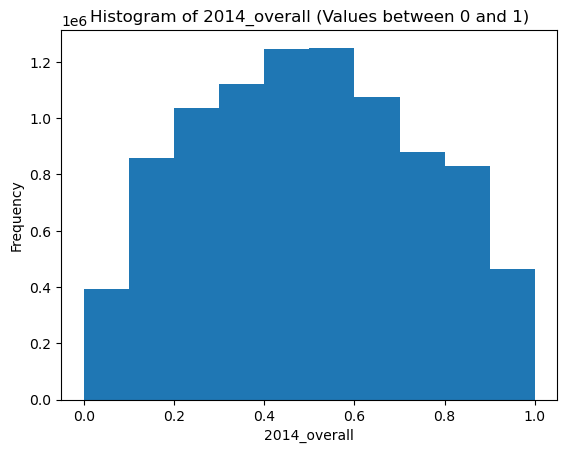

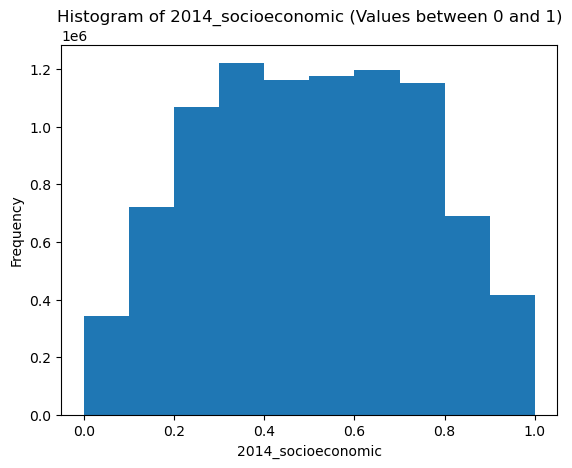

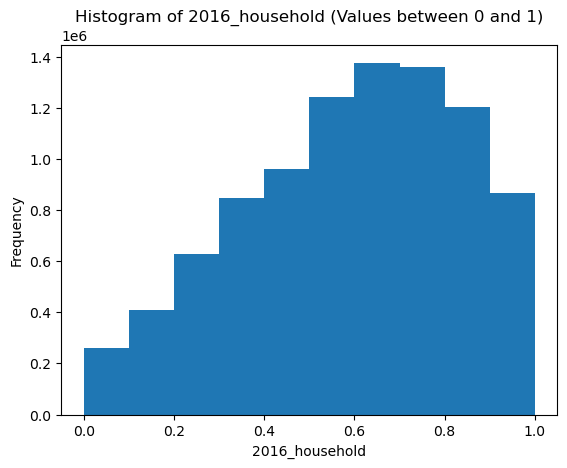

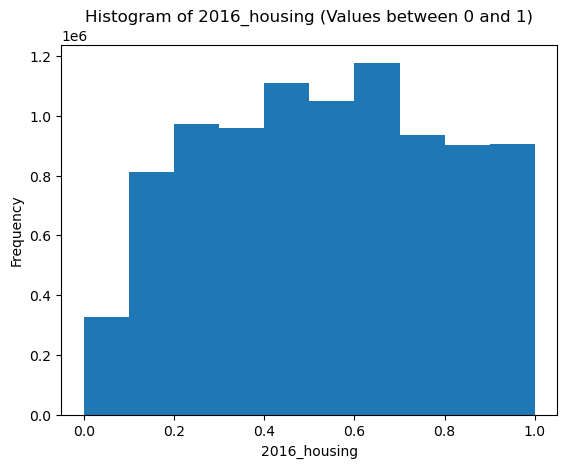

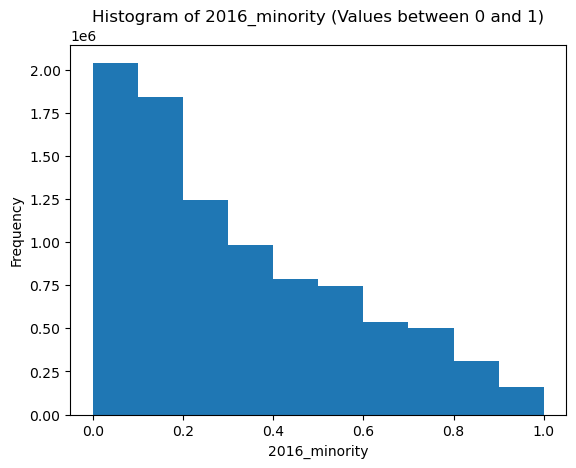

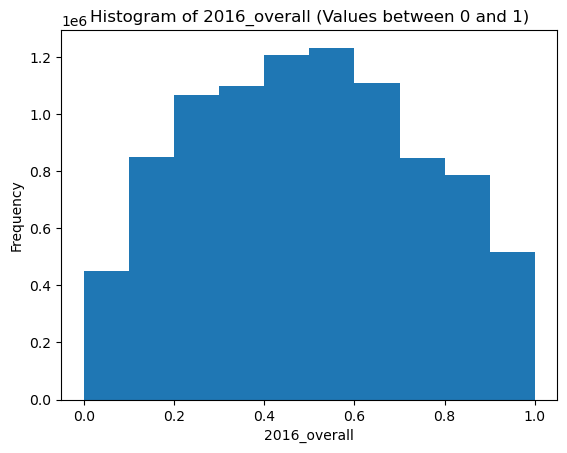

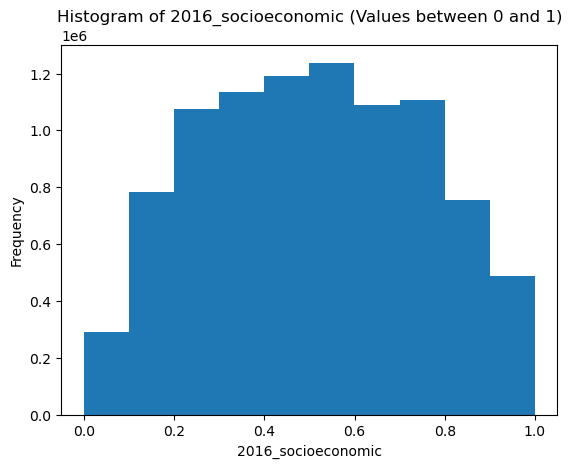

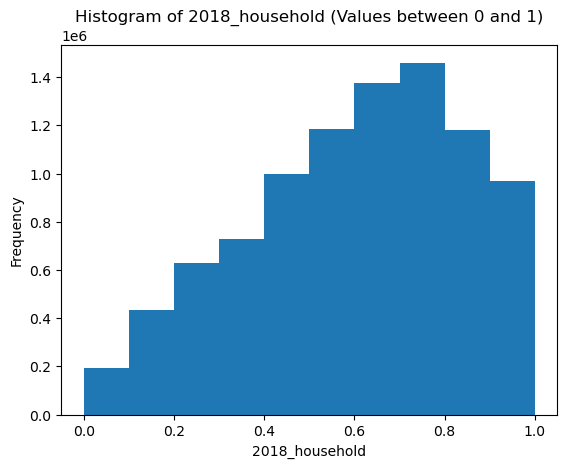

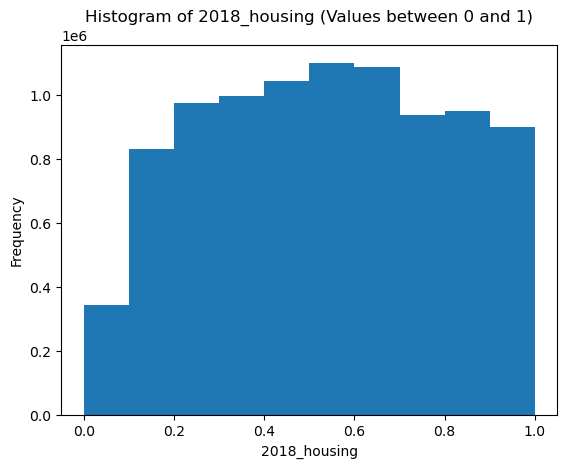

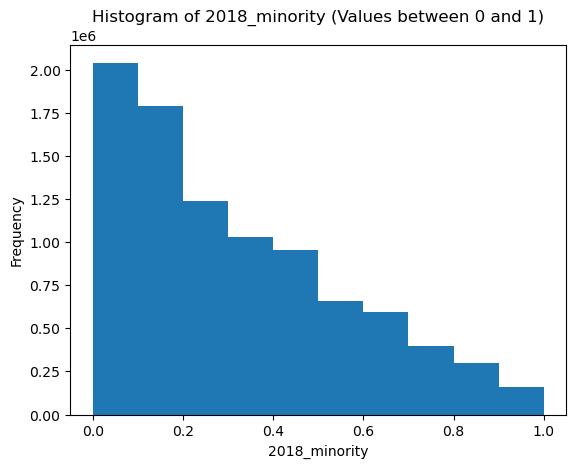

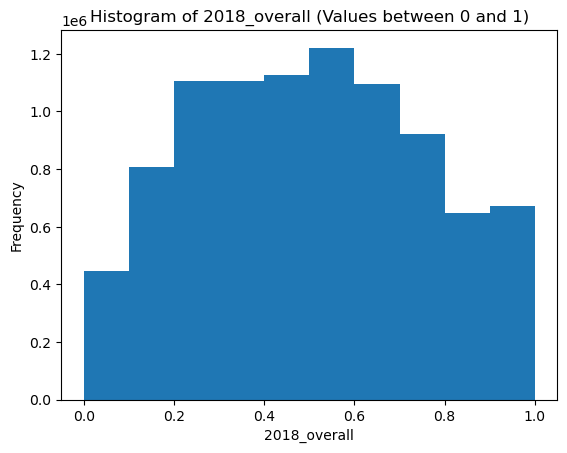

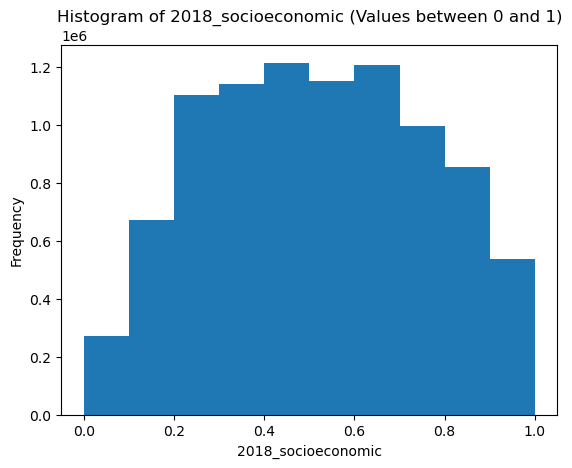

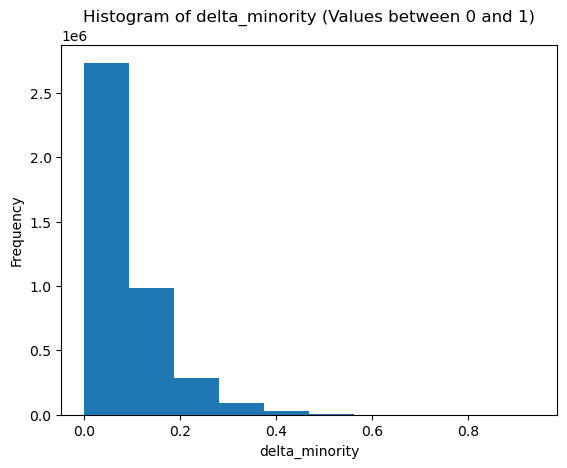

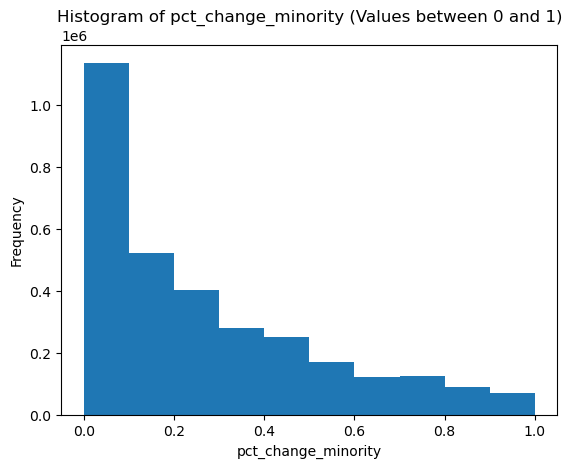

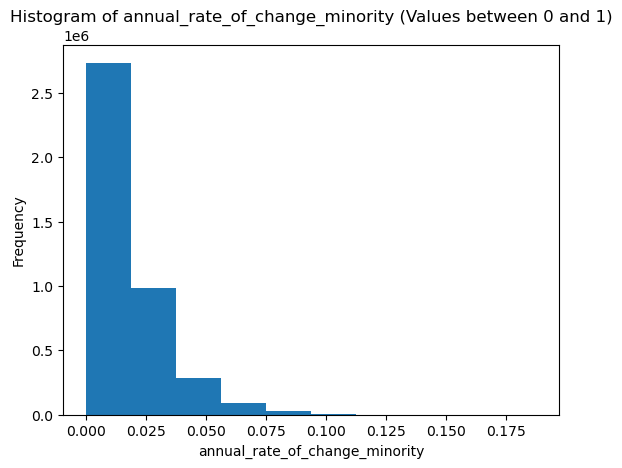

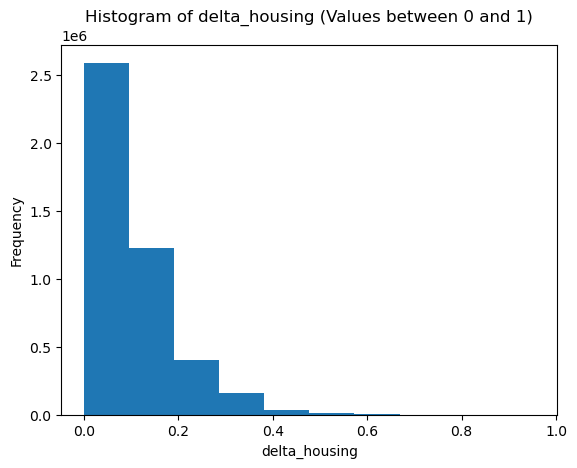

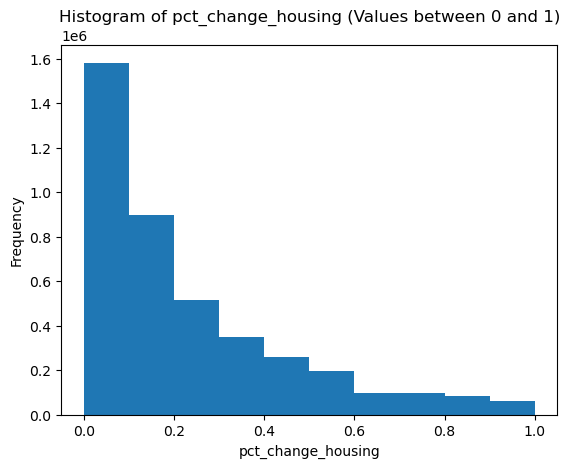

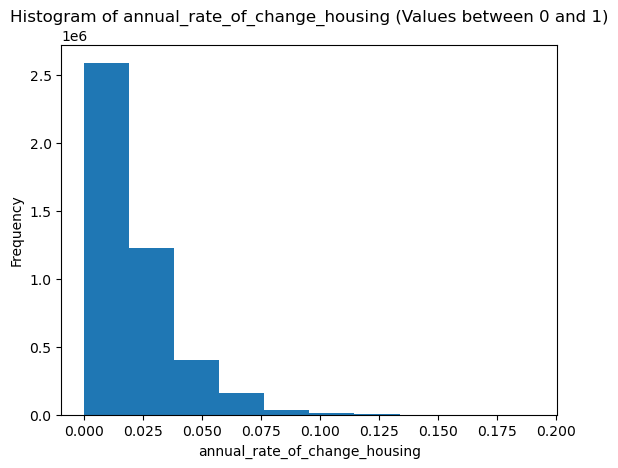

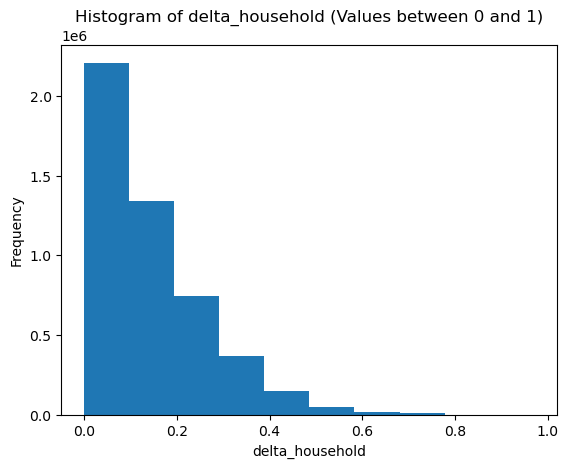

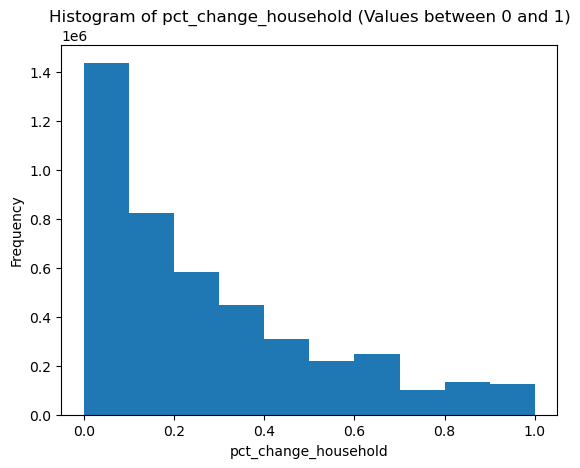

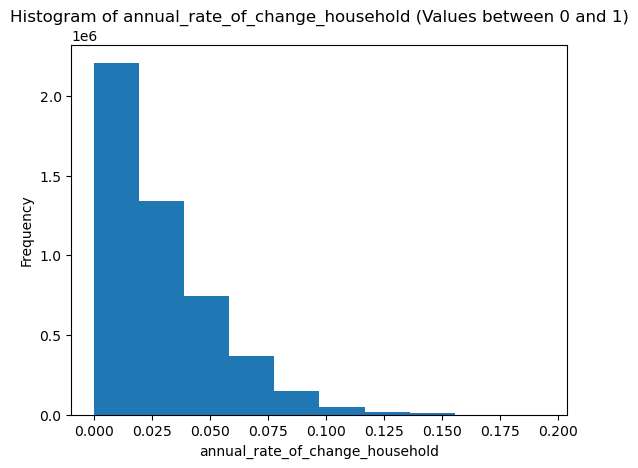

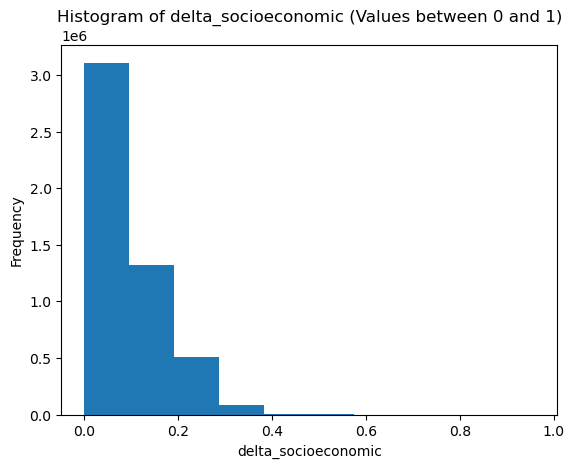

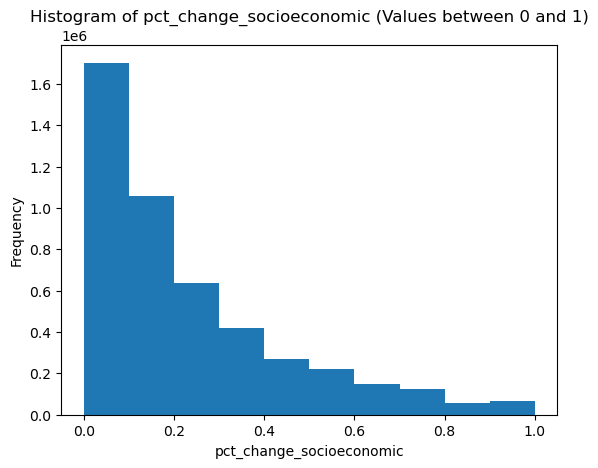

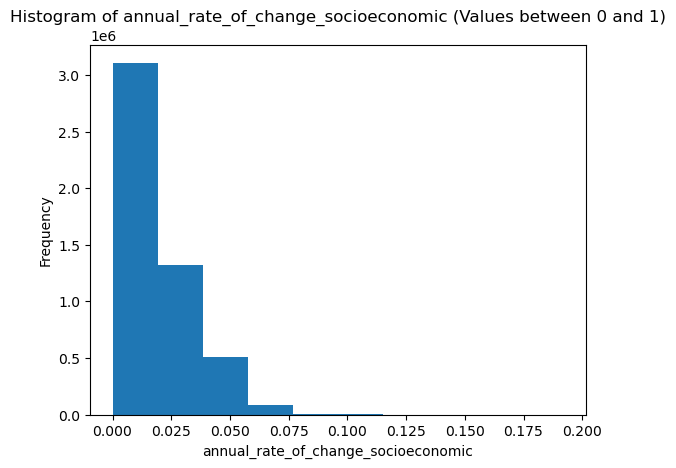

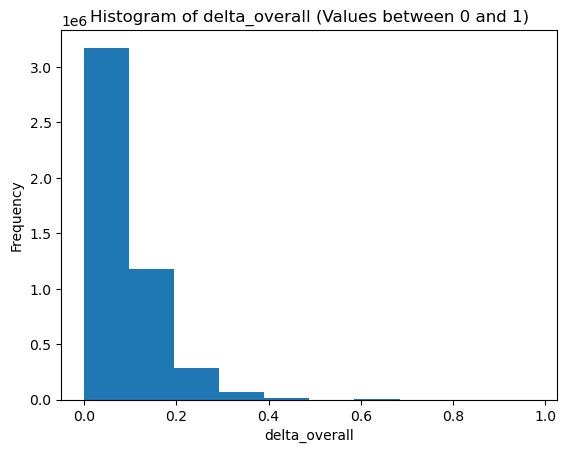

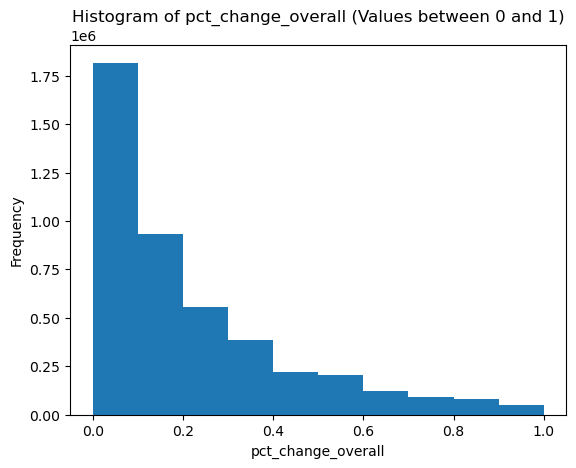

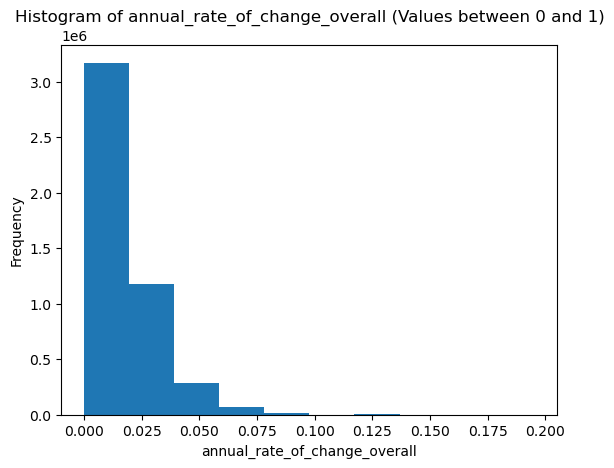

In [23]:
# Plot distributions of variables
variables = []

# Iterate over the column headers
for column in df_svi.columns:
    # Check if the column header is not equal to 'Latitude' and 'Longitude'
    if column != 'Latitude' and column != 'Longitude':
        variables.append(column)

# Create histograms for values between 0 and 1
for variable in variables:
    plt.figure()
    plt.hist(df_svi[(df_svi[variable] >= 0) & (df_svi[variable] <= 1)][variable], bins=10)
    plt.xlabel(variable)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {variable} (Values between 0 and 1)')
    plt.show()

In [24]:
# Create a scatter plot using Seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_svi, x='Latitude', y='Longitude', hue='2018_overall', palette='viridis')

# Set the plot title and axis labels
plt.title('Static Point Map 2018 Overall Social Vulnerability Rank')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Show the plot
plt.show()

In [ ]:
import plotly.graph_objects as go

# Set your Mapbox access token
mapbox_access_token = 'pk.eyJ1IjoianJhc2hpZCIsImEiOiJjbGlsMXhjZ3EwNzF3M2VwZWE1NDZtMjB4In0.CesHDGB6S6qDVDtTTeQxvw'

# Create a trace for the Scattermapbox
trace = go.Scattermapbox(
    lat=df_svi['Latitude'],
    lon=df_svi['Longitude'],
    mode='markers',
    marker=dict(
        size=8,
        color=df_svi['2018_overall'],
        colorscale='Viridis',
        colorbar=dict(title='2018 Overall')
    ),
    text=df_svi['2018_overall'],
    hoverinfo='text'
)

# Define the layout for the Scattermapbox
layout = go.Layout(
    title='Point Map',
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=df_svi['Latitude'].mean(),
            lon=df_svi['Longitude'].mean()
        ),
        pitch=0,
        zoom=10
    ),
)

# Create the figure
fig = go.Figure(data=[trace], layout=layout)

# Show the plot
fig.show("notebook")
